In [1]:
import torch
import time
import warnings
import random
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

from lion_pytorch import Lion 

from collections import defaultdict

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected, add_self_loops, coalesce
from torch_geometric.nn import SAGEConv, GCNConv

from window_slider import Slider

from imblearn.over_sampling import SMOTE

c:\Users\Hafizh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\Hafizh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
c:\Users\Hafizh\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings('ignore')
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True  # Ensures same computations
torch.backends.cudnn.benchmark = False 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# Load the dataset
def load_dataset(file_path):
    df = pd.read_csv(file_path, nrows = 1600000)
    return df

def data_desc(data):
    print()
    print("DATA DESCRIPTION")
    print("Data size (Records, Features):", data.shape)
    
    feature_desc = pd.DataFrame(
                                (zip(data.columns, 
                                    [data[col].dtype for col in data.columns], 
                                    data.nunique(), 
                                    data.isna().sum()/data.shape[0] * 100)), 
                    columns=["Name", "Type", "Unique levels", "Missing Ratio %"])
    print("Features description:\n", feature_desc)
    
    print("Duplicate rows:", data.duplicated().sum())


def split_and_prepare_data(df, train_ratio=0.6, val_ratio=0.2):
    # Drop duplicates to avoid data leakage
    df = df.drop_duplicates()

    # Shuffle before splitting
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Split Train / (Validation + Test) while maintaining class distribution
    strat_split = StratifiedShuffleSplit(n_splits=1, test_size=1 - train_ratio, random_state=42)
    for train_idx, test_val_idx in strat_split.split(df, df['Attack']):
        train = df.iloc[train_idx]
        test_val = df.iloc[test_val_idx]

    # Split Validation / Test
    val_split = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio / (1 - train_ratio), random_state=42)
    for val_idx, test_idx in val_split.split(test_val, test_val['Attack']):
        validation = test_val.iloc[val_idx]
        test = test_val.iloc[test_idx]

    # Print dataset sizes and attack distribution
    print(f"Training set: {train.shape[0]} samples")
    print(train['Attack'].value_counts(), "\n")

    print(f"Validation set: {validation.shape[0]} samples")
    print(validation['Attack'].value_counts(), "\n")

    print(f"Test set: {test.shape[0]} samples")
    print(test['Attack'].value_counts(), "\n")

    # Separate features and labels
    train_target = train["Label"]
    validation_target = validation["Label"]
    test_target = test["Label"]

    # Drop unnecessary columns
    drop_cols = ["Label", "Attack", "Dataset"]
    train_features = train.drop(columns=drop_cols)
    validation_features = validation.drop(columns=drop_cols)
    test_features = test.drop(columns=drop_cols)

    return train_features, train_target, validation_features, validation_target, test_features, test_target


def data_preprocessing(features, scaler=None):
    # Replace inf/-inf with NaN and drop rows
    features = features.replace([np.inf, -np.inf], np.nan).dropna()
    
    # Extract and encode nodes
    snode = features['IPV4_SRC_ADDR'].astype(str) + '-' + features['L4_SRC_PORT'].astype(str)
    dnode = features['IPV4_DST_ADDR'].astype(str) + '-' + features['L4_DST_PORT'].astype(str)
    
    # Drop original columns
    features = features.drop(columns=['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT'])
    
    # Fit the scaler only on the training set
    if scaler is None:
        scaler = MinMaxScaler(feature_range=(0,1))
        features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
    else:
        features = pd.DataFrame(scaler.transform(features), columns=features.columns)
    
    return features, snode, dnode, scaler

     IPV4_SRC_ADDR  L4_SRC_PORT  IPV4_DST_ADDR  L4_DST_PORT  PROTOCOL  \
0  192.168.100.148        65389  192.168.100.7           80         6   
1  192.168.100.148        11154  192.168.100.5           80         6   
2     192.168.1.31        42062   192.168.1.79         1041         6   
3     192.168.1.34        46849   192.168.1.79         9110         6   

   L7_PROTO  IN_BYTES  IN_PKTS  OUT_BYTES  OUT_PKTS  ...  TCP_WIN_MAX_OUT  \
0       7.0       420        3          0         0  ...                0   
1       7.0       280        2         40         1  ...                0   
2       0.0        44        1         40         1  ...                0   
3       0.0        44        1         40         1  ...                0   

   ICMP_TYPE  ICMP_IPV4_TYPE  DNS_QUERY_ID  DNS_QUERY_TYPE  DNS_TTL_ANSWER  \
0      35840             140             0               0               0   
1          0               0             0               0               0   
2          0  

<Axes: >

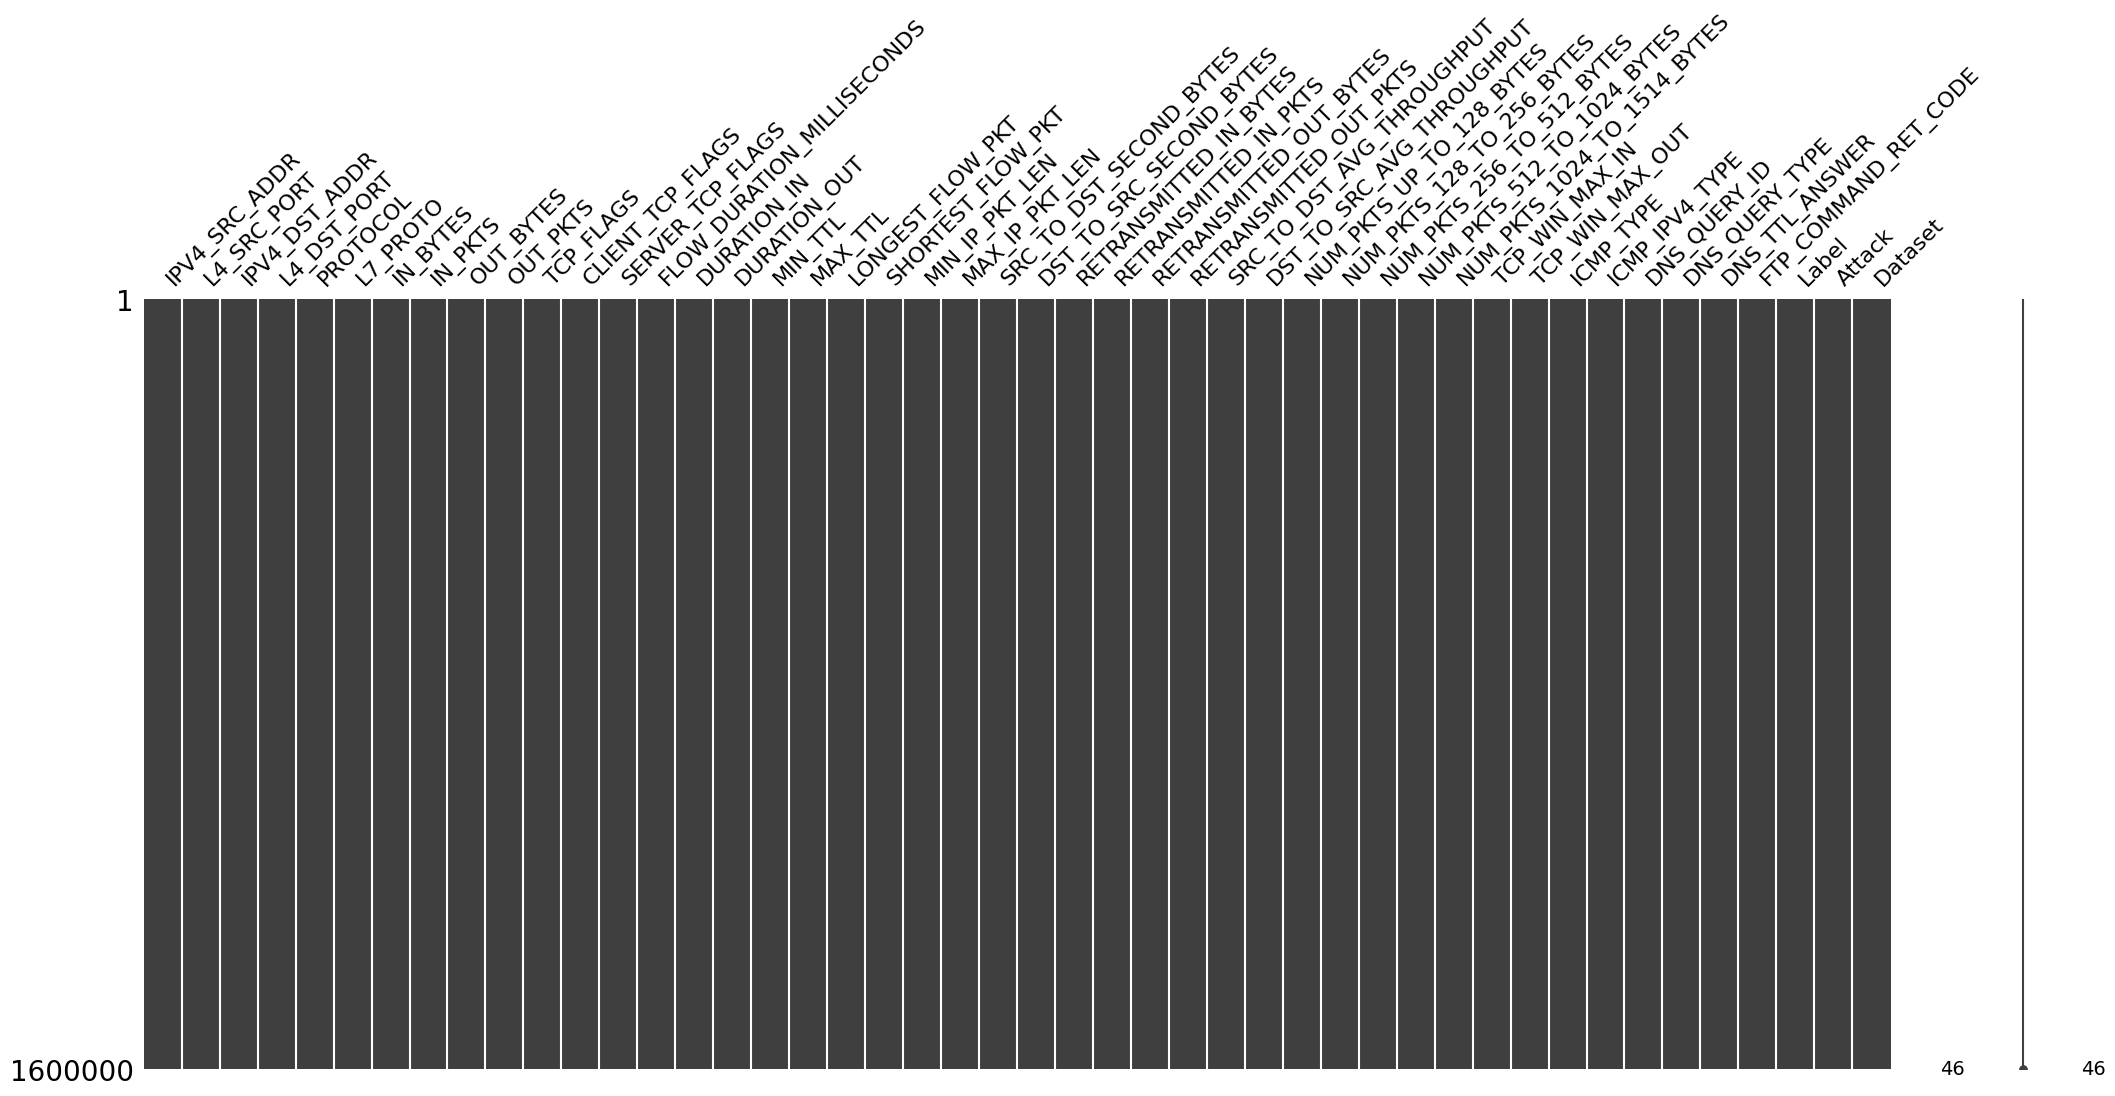

In [4]:
# Prepare the device (Check for cuda availability)
path = 'D:/TA2/Dataset'
# Load the dataset
df = load_dataset(path + "/NF-UQ-NIDS-v2.csv")

# # Check the integrity of the dataset
print(df.head(4))
data_desc(df)
msno.matrix(df)

In [5]:
# Split the dataset
train_features, train_target, validation_features, validation_target, test_features, test_target = split_and_prepare_data(df)

# Preprocess the dataset
train_features, train_snode, train_dnode, scaler = data_preprocessing(train_features)
validation_features, validation_snode, validation_dnode, _ = data_preprocessing(validation_features, scaler)
test_features, test_snode, test_dnode, _ = data_preprocessing(test_features, scaler)

# Check the processed data
print("Processed Features:")
print(train_features.head())
print("\nSource Nodes:")
print(train_snode[:10])
print("\nDestination Nodes:")
print(train_dnode[:10])
print("length")
print(train_features.shape)

Training set: 959976 samples
Attack
Benign            317610
DDoS              274808
DoS               226063
scanning           48148
Reconnaissance     33012
xss                31011
password           14429
injection           8639
Bot                 1828
Brute Force         1610
Infilteration       1482
Exploits             391
Fuzzers              287
Backdoor             236
Generic              220
mitm                  85
ransomware            40
Analysis              33
Theft                 25
Shellcode             17
Worms                  2
Name: count, dtype: int64 

Validation set: 319992 samples
Attack
Benign            105869
DDoS               91603
DoS                75355
scanning           16050
Reconnaissance     11003
xss                10337
password            4810
injection           2879
Bot                  610
Brute Force          537
Infilteration        494
Exploits             130
Fuzzers               96
Backdoor              79
Generic               7

In [6]:
def graph(features, snode, dnode, target, kernel_size=50, train_ratio=0.5, is_train = False):
    
    num_flows = len(features)
    
    # === Structural Edges (Shared Endpoints) ===
    endpoint_groups = defaultdict(list)
    for idx, (s, d) in enumerate(zip(snode, dnode)):
        endpoint_groups[s].append(idx)  # Group by source
        endpoint_groups[d].append(idx)  # Group by destination

    # Generate edges for flows sharing endpoints
    struct_edges = []
    for group in endpoint_groups.values():
        if len(group) > 1:
            pairs = torch.combinations(torch.tensor(group), r=2)
            struct_edges.append(pairs)
    
    struct_edge_index = torch.cat(struct_edges, dim=0).t() if struct_edges else torch.empty((2, 0), dtype=torch.long)
    struct_edge_index = to_undirected(struct_edge_index)
    struct_edge_index = coalesce(struct_edge_index, num_nodes=num_flows)  # Remove duplicates
    struct_edge_index, _ = add_self_loops(struct_edge_index, num_nodes=num_flows)  # Add self-loops

    # === Temporal Edges (Past-Only Connections) ===
    nodes = torch.arange(num_flows)
    offsets = -torch.arange(1, kernel_size + 1)  # Only look backward
    
    # Vectorized implementation for efficiency
    src = nodes.unsqueeze(1) + torch.zeros_like(offsets)
    dst = nodes.unsqueeze(1) + offsets
    mask = (dst >= 0)  # Filter invalid indices
    
    temp_edge_index = torch.stack([
        src[mask].flatten(),
        dst[mask].flatten()
    ])

    if is_train:
        # Mask labels for semi-supervised training (e.g., 50% labeled)
        num_labels = int(num_flows * train_ratio)
        label_mask = torch.zeros(num_flows, dtype=torch.bool)
        label_indices = torch.randperm(num_flows)[:num_labels]  # Random selection
        label_mask[label_indices] = True
    else:
        # Validation/test: Use all labels for evaluation
        label_mask = torch.ones(num_flows, dtype=torch.bool)

    return Data(
        x=torch.tensor(features.values, dtype=torch.float),
        y=torch.tensor(target.values.ravel(), dtype=torch.long),  # Ensure y is 1D
        struct_edge_index=struct_edge_index,
        temp_edge_index=temp_edge_index,
        label_mask=label_mask
    )


In [7]:
def snapshots(features, snode, dnode, target, kernel_size, buffer_size, overlap_count, is_train = False):

    snapshots = []
    idx = np.arange(features.shape[0])
    slider = Slider(buffer_size, overlap_count)
    slider.fit(idx)     

    while True:
        window_data = slider.slide()

        idx_start = window_data[0]
        idx_end = window_data[-1]+1
        snapshot = graph(features=features[idx_start:idx_end], snode=snode[idx_start:idx_end], dnode=dnode[idx_start:idx_end], 
                       target=target[idx_start:idx_end], kernel_size=kernel_size, is_train = is_train)
        snapshots.append(snapshot)

        if slider.reached_end_of_list(): break

    return snapshots

In [8]:
%%time

# Training Snapshot
train_snapshots = snapshots(features=train_features, snode=train_snode, dnode=train_dnode, target=train_target, 
             kernel_size=50, buffer_size=512, overlap_count=256, is_train = True)

print("Training Snapshot")

torch.save(train_snapshots, path+'/train_snapshots.pt')

Training Snapshot
CPU times: total: 1min 18s
Wall time: 26.9 s


In [9]:
%%time

# Validation Snapshot
validation_snapshots = snapshots(features=validation_features, snode=validation_snode, dnode=validation_dnode, target=validation_target, 
                kernel_size=50, buffer_size=512, overlap_count=256)

print("validation Snapshots")

torch.save(validation_snapshots, path+'/validation_snapshots.pt')

validation Snapshots
CPU times: total: 27.5 s
Wall time: 8.48 s


In [10]:
%%time

# Test Snapshot
test_snapshots = snapshots(features=test_features, snode=test_snode, dnode=test_dnode, target=test_target, 
                kernel_size=50, buffer_size=512, overlap_count=256)

print("test Snapshots")

torch.save(test_snapshots, path+'/test_snapshots.pt')

test Snapshots
CPU times: total: 25.2 s
Wall time: 8.81 s


In [11]:
train_snapshots = torch.load(path+'/train_snapshots.pt')
validation_snapshots = torch.load(path+'/validation_snapshots.pt')
test_snapshots = torch.load(path+'/test_snapshots.pt')

# Uses GPU
train_snapshots = [train_snapshot.to(device) for train_snapshot in train_snapshots]
validation_snapshots = [validation_snapshot.to(device) for validation_snapshot in validation_snapshots]
test_snapshots = [test_snapshot.to(device) for test_snapshot in test_snapshots]

# Shuffle
random.shuffle(train_snapshots)
random.shuffle(validation_snapshots)
random.shuffle(test_snapshots)

print("training snapshot : ", len(train_snapshots))
print("validation snapshot : ", len(validation_snapshots))
print("test snapshot : ", len(test_snapshots))

training snapshot :  3749
validation snapshot :  1249
test snapshot :  1249


In [12]:
# --------------------------
# 1. GNN Autoencoder
# --------------------------
class GNN_AE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.activation = nn.ReLU()

        # Structural encoder
        self.struct_enc1 = SAGEConv(input_dim, hidden_dim)
        self.struct_enc2 = SAGEConv(hidden_dim, latent_dim)

        # Temporal encoder
        self.temp_enc1 = SAGEConv(input_dim, hidden_dim)
        self.temp_enc2 = SAGEConv(hidden_dim, latent_dim)

        # fusion weights
        self.alpha = 0.4

        # Decoder
        self.dec1 = SAGEConv(latent_dim, hidden_dim)
        self.dec2 = SAGEConv(hidden_dim, input_dim)

    def encode(self, x, struct_edge_index, temp_edge_index):
        s = self.activation(self.struct_enc1(x, struct_edge_index))
        s = self.struct_enc2(s, struct_edge_index)

        t = self.activation(self.temp_enc1(x, temp_edge_index))
        t = self.temp_enc2(t, temp_edge_index)

        # 🔹 Adaptive fusion
        z = self.alpha * s + (1 - self.alpha) * t
        return z

    def decode(self, z, edge_index):
        h = self.activation(self.dec1(z, edge_index))
        return torch.sigmoid(self.dec2(h, edge_index))

    def forward(self, x, struct_edge_index, temp_edge_index):
        z = self.encode(x, struct_edge_index, temp_edge_index)
        x_recon_s = self.decode(z, struct_edge_index)
        x_recon_t = self.decode(z, temp_edge_index)
        x_recon = (self.alpha * x_recon_s) + ((1 - self.alpha) * x_recon_t)
        return z, x_recon


# --------------------------
# 2. StructTemp-GNN
# --------------------------
class StructTempGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        # Structural dependencies
        self.struct_conv1 = SAGEConv(input_dim, hidden_dim)
        self.struct_conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.struct_conv3 = SAGEConv(hidden_dim, hidden_dim)

        # Temporal dependencies
        self.temp_conv1 = SAGEConv(input_dim, hidden_dim)
        self.temp_conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.temp_conv3 = SAGEConv(hidden_dim, hidden_dim)

    def forward(self, x, struct_edge_index, temp_edge_index):
        # Structural embeddings
        s = F.relu(self.struct_conv1(x, struct_edge_index))
        s = F.relu(self.struct_conv2(s, struct_edge_index))
        s = F.relu(self.struct_conv3(s, struct_edge_index))

        # Temporal embeddings
        t = F.relu(self.temp_conv1(x, temp_edge_index))
        t = F.relu(self.temp_conv2(t, temp_edge_index))
        t = F.relu(self.temp_conv3(t, temp_edge_index))

        return torch.cat([s, t], dim=1)  # 🔹 Output shape: (batch, hidden_dim * 2)


# --------------------------
# 3. Semi-Supervised Model
# --------------------------
class SemiSupervisedStructTempAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        # Shared components
        self.struct_temp = StructTempGNN(input_dim, hidden_dim)
        self.ae = GNN_AE(input_dim, hidden_dim, latent_dim)

        # 🔹 Projection layer for AE latent space
        self.ae_norm = nn.LayerNorm(hidden_dim * 2)
        self.ae_projection = nn.Linear(latent_dim, hidden_dim * 2)

        # 🔹 Classifier
        self.classifier = nn.Linear(hidden_dim * 4, 1)

        self.beta = 0.7

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, data):
        data.x = torch.nan_to_num(data.x, nan=0.0, posinf=1.0, neginf=-1.0)
        data.x = torch.clamp(data.x, 0, 1)

        st_emb = self.struct_temp(data.x, data.struct_edge_index, data.temp_edge_index)
        ae_latent, x_recon = self.ae(data.x, data.struct_edge_index, data.temp_edge_index)

        # 🔹 Project AE latent space to match hidden_dim * 2
        ae_latent = self.ae_projection(ae_latent)
        ae_latent = self.ae_norm(ae_latent) 

        # 🔹 Concatenation
        combined_emb = torch.cat([st_emb, ae_latent], dim=1)

        logits = self.classifier(combined_emb)

        return combined_emb, x_recon, logits.squeeze()


    def loss(self, data):
        combined_emb, x_recon, logits = self.forward(data)

        # 🔹 MSE Loss 
        recon_loss = F.mse_loss(x_recon, torch.clamp(data.x, 0, 1))

        # 🔹 BCE Logits
        cls_loss = 0
        if self.training and hasattr(data, 'label_mask'):
            y_true = torch.clamp(data.y[data.label_mask].float(), min=1e-7, max=1 - 1e-7)
            logits_clamped = torch.clamp(logits[data.label_mask], min=-10, max=10)

            cls_loss = F.binary_cross_entropy_with_logits(logits_clamped, y_true)

        total_loss = self.beta * cls_loss + (1 - self.beta) * recon_loss if cls_loss != 0 else recon_loss


        # 🔹 Debugging
        if total_loss.item() > 1e6:
            print("⚠️ Warning: Loss is extremely high:", total_loss.item())

        return total_loss


In [ ]:
# Set up matplotlib for Jupyter display
%matplotlib inline

# Plotting functions
def plot_confusion_matrix(y_true, y_pred, classes=['Normal', 'Anomaly'], title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentage per class
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=classes, yticklabels=classes,
                annot_kws={"size": 12})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title + ' (%)')
    plt.show()

def plot_f1_curves(train_f1, val_f1):
    plt.figure(figsize=(10, 5))
    plt.plot(train_f1, label='Training F1')
    plt.plot(val_f1, label='Validation F1')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.ylim(0, 1)  # Keep F1 scale between 0-1
    plt.legend()
    plt.title('F1 Score Evolution')
    plt.show()

def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()

# Modified training function with F1 tracking
def train_model(model, train_snapshots, val_snapshots, optimizer, 
               scheduler=None, num_epochs=50, patience=5):
    best_val_acc = 0.0
    patience_counter = 0
    train_loss_history = []
    val_loss_history = []
    train_f1_history = []
    val_f1_history = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        total_correct = 0
        total_samples = 0
        all_train_preds = []
        all_train_labels = []

        # Training loop
        for data in train_snapshots:
            data = data.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            st_emb, x_recon, logits = model(data)
            loss = model.loss(data)
            
            # Backward pass
            loss.backward()
            optimizer.step()

            # Accumulate metrics
            epoch_train_loss += loss.item()
            preds = (logits >= 0).long()
            labels = data.y
            
            # Store predictions/labels for F1 calculation
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())
            
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

        # Calculate epoch metrics
        avg_train_loss = epoch_train_loss / len(train_snapshots)
        train_acc = total_correct / total_samples if total_samples > 0 else 0.0
        train_loss_history.append(avg_train_loss)
        
        # Calculate training F1
        train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted', zero_division=0)
        train_f1_history.append(train_f1)

        # Validation
        val_metrics = evaluate_model(model, val_snapshots)
        val_loss_history.append(val_metrics[0])
        val_f1_history.append(val_metrics[4])  # Get F1 from metrics tuple

        # Print epoch summary
        print(f"\nEpoch {epoch+1:02d}/{num_epochs}:")
        print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Train F1: {train_f1:.4f}")
        print(f"  Val Loss: {val_metrics[0]:.4f} | Val Acc: {val_metrics[1]*100:.2f}% | Val F1: {val_metrics[4]:.4f}")

        # Early stopping and checkpointing
        if val_metrics[1] > best_val_acc:
            best_val_acc = val_metrics[1]
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break

        # Learning rate scheduling
        if scheduler:
            scheduler.step()

    # Plot all curves
    plot_loss_curves(train_loss_history, val_loss_history)
    plot_f1_curves(train_f1_history, val_f1_history)
    
    return train_loss_history, val_loss_history, train_f1_history, val_f1_history

# Enhanced evaluation function
def evaluate_model(model, snapshots):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    inference_times = []

    with torch.no_grad():
        for data in snapshots:
            data = data.to(device)
            
            # Timing inference
            start_time = time.time()
            st_emb, x_recon, logits = model(data)
            inference_times.append(time.time() - start_time)
            
            # Calculate loss
            loss = model.loss(data)
            total_loss += loss.item()

            # Get predictions
            preds = (logits >= 0).long()
            labels = data.y
            
            # Accumulate metrics
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    avg_loss = total_loss / len(snapshots)
    accuracy = total_correct / total_samples if total_samples > 0 else 0.0
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    # Calculate timing metrics
    avg_inference_time = sum(inference_times) / len(inference_times)
    if total_samples > 0:
        avg_inference_per_flow = avg_inference_time / (total_samples / len(snapshots))
    else:
        avg_inference_per_flow = 0

    return (avg_loss, accuracy, precision, recall, f1,
            avg_inference_time, avg_inference_per_flow,
            all_labels, all_preds)

# Initialize Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SemiSupervisedStructTempAE(
    input_dim=39,
    hidden_dim=128,
    latent_dim=128,
).to(device)

optimizer = Lion(model.parameters(), lr=1e-5, weight_decay=1e-5)

# Training Execution
train_losses, val_losses, train_f1s, val_f1s = train_model(
    model=model,
    train_snapshots=train_snapshots,
    val_snapshots=validation_snapshots,
    optimizer=optimizer,
    num_epochs=15,
    patience=5
)

# Final Evaluation
def full_evaluation(snapshots, set_name="Test"):
    metrics = evaluate_model(model, snapshots)
    
    print(f"\n{set_name} Metrics:")
    print(f"  Loss: {metrics[0]:.8f}")
    print(f"  Accuracy: {metrics[1]:.8f}%")
    print(f"  Precision: {metrics[2]:.8f}")
    print(f"  Recall: {metrics[3]:.8f}")
    print(f"  F1 Score: {metrics[4]:.8f}")
    print(f"  Inference Time/Snapshot: {metrics[5]:.8f}s")
    print(f"  Inference Time/Flow: {metrics[6]:.8f}s")
    
    # Plot confusion matrix
    plot_confusion_matrix(metrics[7], metrics[8], title=f'{set_name} Confusion Matrix')

# Run evaluations
full_evaluation(validation_snapshots, "Validation")
full_evaluation(test_snapshots)


Epoch 01/15:
  Train Loss: 0.1573 | Train Acc: 91.49% | Train F1: 0.9153
  Val Loss: 0.0186 | Val Acc: 96.08% | Val F1: 0.9606

Epoch 02/15:
  Train Loss: 0.0630 | Train Acc: 96.43% | Train F1: 0.9643
  Val Loss: 0.0113 | Val Acc: 96.72% | Val F1: 0.9673

Epoch 03/15:
  Train Loss: 0.0540 | Train Acc: 96.74% | Train F1: 0.9674
  Val Loss: 0.0069 | Val Acc: 96.92% | Val F1: 0.9694

Epoch 04/15:
  Train Loss: 0.0497 | Train Acc: 96.88% | Train F1: 0.9688
  Val Loss: 0.0046 | Val Acc: 97.04% | Val F1: 0.9705

Epoch 05/15:
  Train Loss: 0.0469 | Train Acc: 96.98% | Train F1: 0.9698
  Val Loss: 0.0029 | Val Acc: 97.14% | Val F1: 0.9715

Epoch 06/15:
  Train Loss: 0.0450 | Train Acc: 97.05% | Train F1: 0.9706
  Val Loss: 0.0018 | Val Acc: 97.21% | Val F1: 0.9723

Epoch 07/15:
  Train Loss: 0.0434 | Train Acc: 97.11% | Train F1: 0.9712
  Val Loss: 0.0012 | Val Acc: 97.29% | Val F1: 0.9730

Epoch 08/15:
  Train Loss: 0.0421 | Train Acc: 97.19% | Train F1: 0.9719
  Val Loss: 0.0008 | Val Acc: 